In [ ]:
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import sparse
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sknetwork.clustering import Louvain

In [ ]:
FEATURE_TYPES = ['pca', 'umap']
REPRESENTATIONS = ['pge', 'resnet50', 'inceptionv3', 'vgg16']

# Load Data Content
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')

data_content = {
    'pge': pge_content,
    'resnet50': resnet50_content,
    'inceptionv3': inceptionv3_content,
    'vgg16': vgg16_content
}

In [ ]:
# Feature Extraction
pge_pca_feature = data_content['pge']['pca_feature'][...]
resnet50_pca_feature = data_content['resnet50']['pca_feature'][...]
inceptionv3_pca_feature = data_content['inceptionv3']['pca_feature'][...]
vgg16_pca_feature = data_content['vgg16']['pca_feature'][...]

pge_umap_feature = data_content['pge']['umap_feature'][...]
resnet50_umap_feature = data_content['resnet50']['umap_feature'][...]
inceptionv3_umap_feature = data_content['inceptionv3']['umap_feature'][...]
vgg16_umap_feature = data_content['vgg16']['umap_feature'][...]

'''
pge_pca_feature = pge_content['pca_feature'][...]
resnet50_pca_feature = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature = vgg16_content['pca_feature'][...]

pge_umap_feature = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]
inceptionv3_umap_feature = inceptionv3_content['umap_feature'][...]
vgg16_umap_feature = vgg16_content['umap_feature'][...]
'''

In [ ]:
# Labels Extraction
pge_filename = np.squeeze(data_content['pge']['file_name'])
pge_filename = np.array([str(x) for x in pge_filename])
pge_labels = np.array([x.split('/')[2] for x in pge_filename])

resnet50_filename = np.squeeze(data_content['resnet50']['file_name'])
resnet50_filename = np.array([str(x) for x in resnet50_filename])
resnet50_labels = np.array([x.split('/')[2] for x in resnet50_filename])

inceptionv3_filename = np.squeeze(data_content['inceptionv3']['file_name'])
inceptionv3_filename = np.array([str(x) for x in inceptionv3_filename])
inceptionv3_labels = np.array([x.split('/')[2] for x in inceptionv3_filename])

vgg16_filename = np.squeeze(data_content['vgg16']['file_name'])
vgg16_filename = np.array([str(x) for x in vgg16_filename])
vgg16_labels = np.array([x.split('/')[2] for x in vgg16_filename])

In [ ]:
# Testing Data for pca
random.seed(0)
selected_index = random.sample(list(np.arange(len(pge_pca_feature))), 200)
pge_test_pca_data = pge_pca_feature[selected_index]
pge_test_pca_label = pge_labels[selected_index]

selected_index = random.sample(list(np.arange(len(resnet50_pca_feature))), 200)
resnet50_test_pca_data = resnet50_pca_feature[selected_index]
resnet50_test_pca_label = resnet50_labels[selected_index]

selected_index = random.sample(list(np.arange(len(inceptionv3_pca_feature))), 200)
inceptionv3_test_pca_data = inceptionv3_pca_feature[selected_index]
inceptionv3_test_pca_label = inceptionv3_labels[selected_index]

selected_index = random.sample(list(np.arange(len(vgg16_pca_feature))), 200)
vgg16_test_pca_data = vgg16_pca_feature[selected_index]
vgg16_test_pca_label = vgg16_labels[selected_index]

In [ ]:
# Louvain Clustering
def louvain_clustering(test_data, resolution=0.9, modularity='Newman', random_state=0):
    louvain_model = Louvain(resolution=resolution, modularity=modularity, random_state=random_state)
    adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(test_data)))
    louvain_assignment = louvain_model.fit_transform(adjacency_matrix)
    labels = louvain_model.fit_predict(adjacency_matrix)
    # Check if there is at least two clusters
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        print("Skipping clustering as it resulted in less than two clusters.")
        return None, None
    return louvain_assignment, labels

In [ ]:
# Initialize variables to store best cluster size and corresponding scores
best_clusters = {"pge": {"silhouette": {"size": 0, "score": -1}, "v_measure": {"size": 0, "score": -1}},
                 "vgg16": {"silhouette": {"size": 0, "score": -1}, "v_measure": {"size": 0, "score": -1}},
                 "inceptionv3": {"silhouette": {"size": 0, "score": -1}, "v_measure": {"size": 0, "score": -1}},
                 "resnet50": {"silhouette": {"size": 0, "score": -1}, "v_measure": {"size": 0, "score": -1}}}  # Added resnet50, inceptionv3, and vgg16

# Find the best resolution for each representation
best_resolution = {"pge": 0, "vgg16": 0, "inceptionv3": 0, "resnet50": 0}  # Added resnet50, inceptionv3, and vgg16

# K-means clustering with n_init set to suppress the future warning
num_clusters_list = range(2, 17)  # Changed the range to 2 to 16

# Calculate silhouette and v-measure scores for each cluster size
silhouette_scores_pge = [silhouette_score(pge_test_pca_data, louvain_clustering(pge_test_pca_data, resolution=best_resolution, modularity='Newman', random_state=0))]
v_measure_scores_pge = [v_measure_score(pge_test_pca_labels, louvain_clustering(pge_test_pca_data, resolution=best_resolution, modularity='Newman', random_state=0)[1]) for k in num_clusters_list]

silhouette_scores_resnet50 = [silhouette_score(resnet50_test_pca_data, louvain_clustering(resnet50_test_pca_data, resolution=best_resolution, modularity='Newman', random_state=0)[1]) for k in num_clusters_list] 
v_measure_scores_resnet50 = [v_measure_score(resnet50_test_pca_labels, louvain_clustering(resnet50_test_pca_data, resolution=best_resolution, num_clusters=k)[1]) for k in num_clusters_list]

silhouette_scores_inceptionv3 = [silhouette_score(inceptionv3_test_pca_data, louvain_clustering(inceptionv3_test_pca_data, resolution=best_resolution, num_clusters=k)[1]) for k in num_clusters_list]
v_measure_scores_inceptionv3 = [v_measure_score(inceptionv3_test_pca_labels, louvain_clustering(inceptionv3_test_pca_data, resolution=best_resolution, num_clusters=k)[1]) for k in num_clusters_list]

silhouette_scores_vgg16 = [silhouette_score(vgg16_test_pca_data, louvain_clustering(vgg16_test_pca_data, resolution=best_resolution, num_clusters=k)[1]) for k in num_clusters_list]
v_measure_scores_vgg16 = [v_measure_score(vgg16_test_pca_labels, louvain_clustering(vgg16_test_pca_data, resolution=best_resolution, num_clusters=k)[1]) for k in num_clusters_list]

# Find the best cluster size and corresponding scores for each representation
best_clusters["pge"]["silhouette"]["size"] = num_clusters_list[silhouette_scores_pge.index(max(silhouette_scores_pge))]
best_clusters["pge"]["silhouette"]["score"] = max(silhouette_scores_pge)
best_clusters["pge"]["v_measure"]["size"] = num_clusters_list[v_measure_scores_pge.index(max(v_measure_scores_pge))]
best_clusters["pge"]["v_measure"]["score"] = max(v_measure_scores_pge)

best_clusters["resnet50"]["silhouette"]["size"] = num_clusters_list[silhouette_scores_resnet50.index(max(silhouette_scores_resnet50))]
best_clusters["resnet50"]["silhouette"]["score"] = max(silhouette_scores_resnet50)
best_clusters["resnet50"]["v_measure"]["size"] = num_clusters_list[v_measure_scores_resnet50.index(max(v_measure_scores_resnet50))]
best_clusters["resnet50"]["v_measure"]["score"] = max(v_measure_scores_resnet50)

best_clusters["inceptionv3"]["silhouette"]["size"] = num_clusters_list[silhouette_scores_inceptionv3.index(max(silhouette_scores_inceptionv3))]
best_clusters["inceptionv3"]["silhouette"]["score"] = max(silhouette_scores_inceptionv3)
best_clusters["inceptionv3"]["v_measure"]["size"] = num_clusters_list[v_measure_scores_inceptionv3.index(max(v_measure_scores_inceptionv3))]
best_clusters["inceptionv3"]["v_measure"]["score"] = max(v_measure_scores_inceptionv3)

best_clusters["vgg16"]["silhouette"]["size"] = num_clusters_list[silhouette_scores_vgg16.index(max(silhouette_scores_vgg16))]
best_clusters["vgg16"]["silhouette"]["score"] = max(silhouette_scores_vgg16)
best_clusters["vgg16"]["v_measure"]["size"] = num_clusters_list[v_measure_scores_vgg16.index(max(v_measure_scores_vgg16))]
best_clusters["vgg16"]["v_measure"]["score"] = max(v_measure_scores_vgg16)

In [ ]:
# Dataset Preparation
datasets = {}
for representation in REPRESENTATIONS:
     for feature_type in FEATURE_TYPES:
        if feature_type == 'pca':
            datasets[representation] = {
                'pca': data_content[representation]['pca_feature'][...],
                'label': data_content[representation]['label'][...]
            }
        elif feature_type == 'umap':
            datasets[representation] = {
                'umap': data_content[representation]['umap_feature'][...],
                'label': data_content[representation]['label'][...]
            }
        else:
          datasets[representation] = {}

In [ ]:
# Populate datasets dictionary
# for representation in REPRESENTATIONS

In [ ]:
from scipy import sparse
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sknetwork.clustering import Louvain  # search for scikit-network when trying to install

def get_labels(data_content, representation):
    filename = np.squeeze(data_content[representation]['file_name'])
    filename = np.array([str(x) for x in filename])
    labels = np.array([x.split('/')[2] for x in filename])
    return labels



# Clustering each dataset using Louvain
clustered_datasets = {}
for representation in REPRESENTATIONS:
    clustered_datasets[representation] = {}
    for feature_type in FEATURE_TYPES:
        dataset = datasets[representation][feature_type]
        clusters = louvain_clustering(dataset)
        clustered_datasets[representation][feature_type] = clusters
        print(dataset.shape)
        print(clusters)
        print(f"Clustering for {representation} - {feature_type} completed.")


# Evaluation
for representation in REPRESENTATIONS:
    for feature_type in FEATURE_TYPES:
        clusters = clustered_datasets[representation][feature_type]
        dataset = datasets[feature_type][representation]
        
        # Silhouette Score
        silhouette_avg = silhouette_score(dataset, clusters)
        print(f"Silhouette Score for {representation} - {feature_type}: {silhouette_avg}")

        # Vmeasure Score
        labels = get_labels(data_content[representation], representation)
        vmeasure = v_measure_score(labels, clusters)
        print(f"Vmeasure Score for {representation} - {feature_type}: {vmeasure}")

        # Visualization (assuming 2D data for simplicity)
        pca = PCA(n_components=2)
        umap_model = umap.UMAP(n_components=2)
        reduced_data = pca.fit_transform(dataset)
        umap_data = umap_model.fit_transform(dataset)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', s=10)
        plt.title('PCA Clusters')

        plt.subplot(1, 3, 2)
        plt.scatter(umap_data[:, 0], umap_data[:, 1], c=clusters, cmap='viridis', s=10)
        plt.title('UMAP Clusters')

        plt.subplot(1, 3, 3)
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', s=10)
        plt.title('Ground Truth')

        plt.suptitle(f'Clustering Visualization - {representation} - {feature_type}')
        plt.show()

In [ ]:
import h5py
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.preprocessing import MinMaxScaler
from sknetwork.clustering import Louvain
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from scipy import sparse

# Load data content
def load_data_content():
    pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
    vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

    pge_content = h5py.File(pge_path, mode='r')
    vgg16_content = h5py.File(vgg16_path, mode='r')

    return {
        'pge': pge_content,
        'vgg16': vgg16_content
    }

data_content = load_data_content()

def get_labels(data_content, representation):
    filename = np.squeeze(data_content[representation]['file_name'])
    filename = np.array([str(x) for x in filename])
    labels = np.array([x.split('/')[2] for x in filename])
    return labels

# Visualize Clusters
def visualize_clusters(data, clusters, title):
    pca = PCA(n_components=2)
    umap_model = TSNE(n_components=2)
    reduced_data = pca.fit_transform(data)
    umap_data = umap_model.fit_transform(data)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', s=10)
    plt.title('PCA Clusters')

    plt.subplot(1, 3, 2)
    plt.scatter(umap_data[:, 0], umap_data[:, 1], c=clusters, cmap='viridis', s=10)
    plt.title('UMAP Clusters')

    plt.subplot(1, 3, 3)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', s=10)
    plt.title('Ground Truth')

    plt.suptitle(title)
    plt.show()

# Analyze Louvain Clustering Performance for 'pge'
pge_data = data_content['pge']['umap_feature'][...]
pge_labels = get_labels(data_content, 'pge')

best_silhouette = -1
best_resolution = 0

for resolution in np.arange(0.9, 1.0, 0.8):
    _, clusters = louvain_clustering(pge_data, resolution=resolution)
    silhouette_avg = silhouette_score(pge_data, clusters)
    #if clusters is None:
     #   continue

    print(f"Resolution: {resolution}, Silhouette Score: {silhouette_avg}")

    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_resolution = resolution

# Visualize the best-performing clustering for 'pge'
best_pge_clusters = louvain_clustering(pge_data, resolution=best_resolution)[1]
visualize_clusters(pge_data, best_pge_clusters, f'Best Louvain Clustering for PGE (Resolution={best_resolution})')

# Analyze Louvain Clustering Performance for 'vgg16'
vgg_data = data_content['vgg16']['umap_feature'][...]
vgg_labels = get_labels(data_content, 'vgg16')

best_silhouette = -1
best_resolution = 0

for resolution in np.arange(0.9, 1.0, 0.8):
    _, clusters = louvain_clustering(vgg_data, resolution=resolution)
    silhouette_avg = silhouette_score(vgg_data, clusters)
    #if clusters is None:
     #   continue

    print(f"Resolution: {resolution}, Silhouette Score: {silhouette_avg}")

    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_resolution = resolution

# Visualize the best-performing clustering for 'vgg16'
best_vgg_clusters = louvain_clustering(vgg_data, resolution=best_resolution)[1]
visualize_clusters(vgg_data, best_vgg_clusters, f'Best Louvain Clustering for VGG16 (Resolution={best_resolution})')


                # Calculate the percentage of tissue types in each cluster
                cluster_percentages = []
                for labels in louvain_assignment:
                    cluster_counts = np.unique(labels, return_counts=True)[1]
                    cluster_percentage = cluster_counts / np.sum(cluster_counts) * 100
                    cluster_percentages.append(cluster_percentage)

                # Create a dataframe to store the cluster percentages
                df_cluster_percentages = pd.DataFrame(cluster_percentages, columns=np.unique(labels))

                # Plot the cluster percentages
                plt.figure(figsize=(12, 6))
                sns.boxplot(data=df_cluster_percentages)
                plt.xlabel('Cluster')
                plt.ylabel('Percentage of Tissue Types')
                plt.title('Individual Cluster Percentages')
                plt.show()

In [13]:
import h5py
import numpy as np
import random
from sklearn.metrics import silhouette_score, v_measure_score
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sknetwork.clustering import Louvain
import matplotlib.pyplot as plt

# Load Data Content
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')

data_content = {
    'pge': pge_content,
    'resnet50': resnet50_content,
    'inceptionv3': inceptionv3_content,
    'vgg16': vgg16_content
}

In [14]:
# Constants
feature_types = ['pca', 'umap']
representations = ['pge', 'resnet50', 'inceptionv3', 'vgg16']
modularity_options = ['Dugue', 'Newman', 'Potts']
random_state = 0
results_headers = dict({'Metrics': ['count', 'silhouette', 'V-measure']})

# Prepare Datasets
datasets = {representation: {feature: data_content[representation]['pca_feature'][...] for feature in feature_types} for representation in representations}
best_cluster_sizes = {}
best_scores = {}

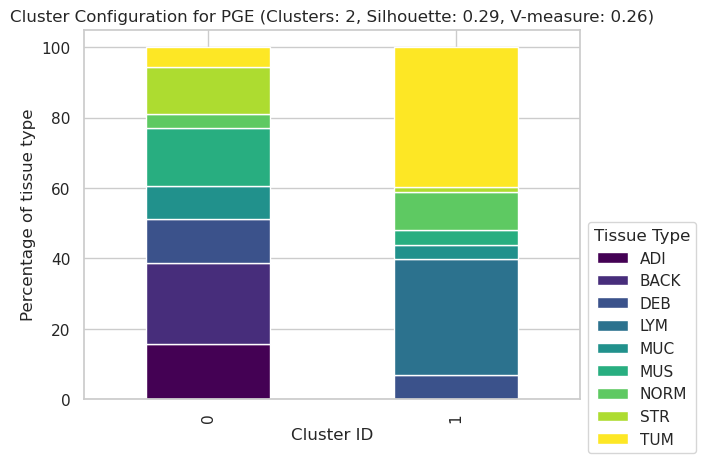

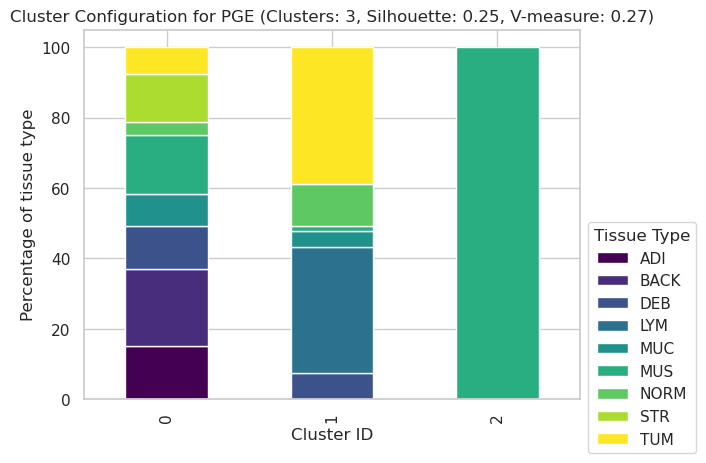

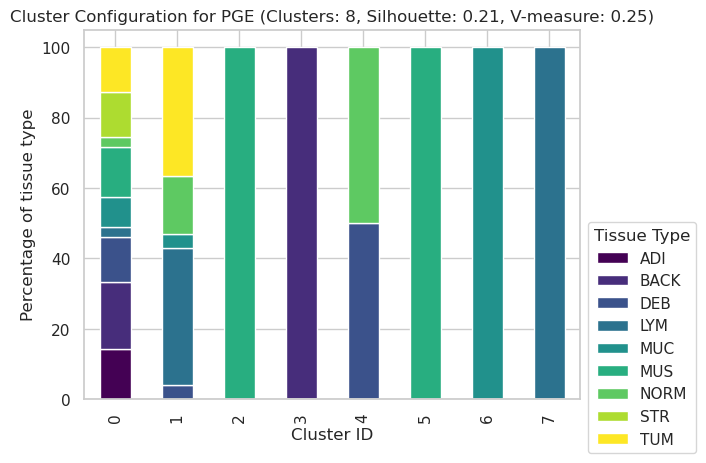

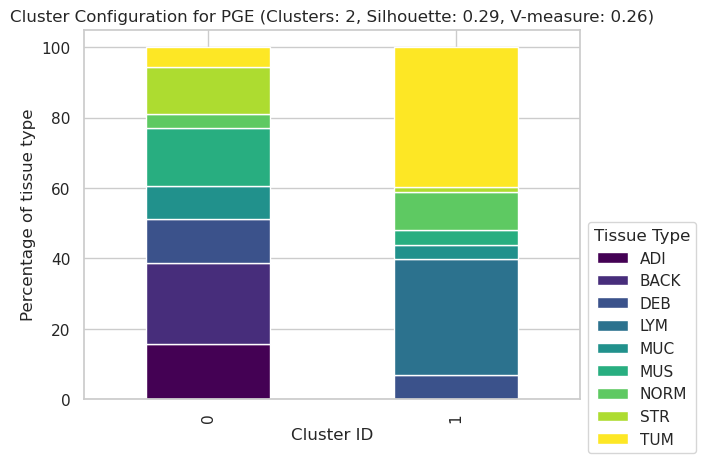

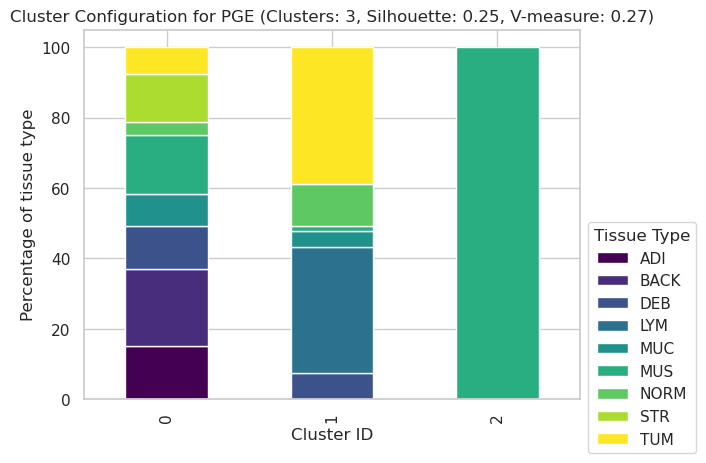

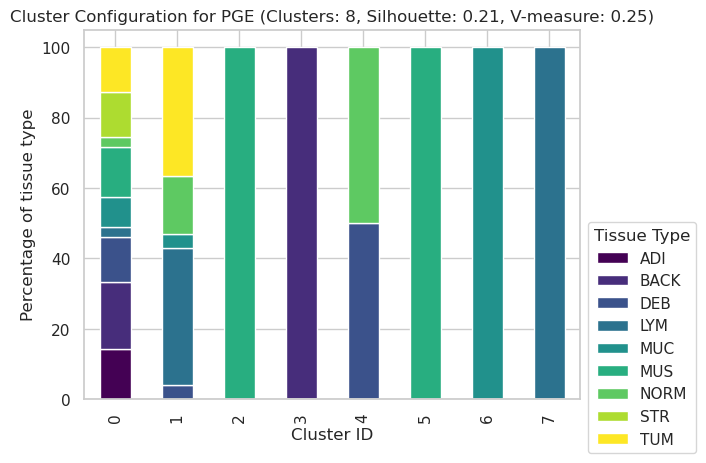

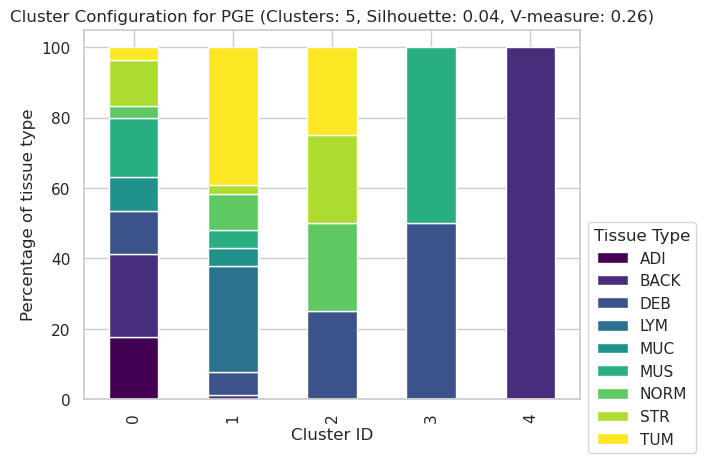

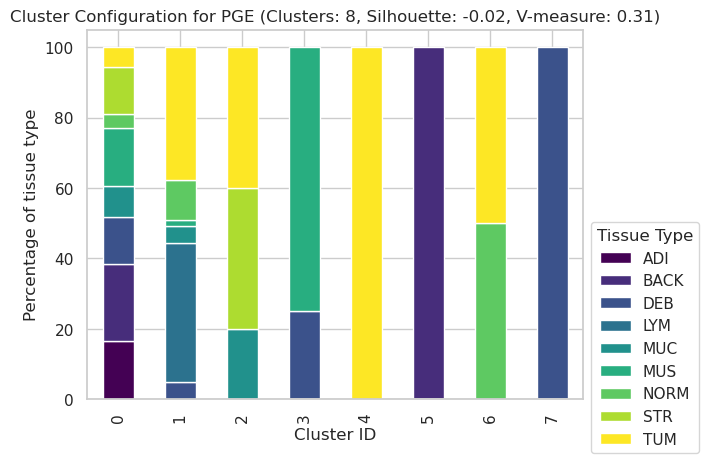

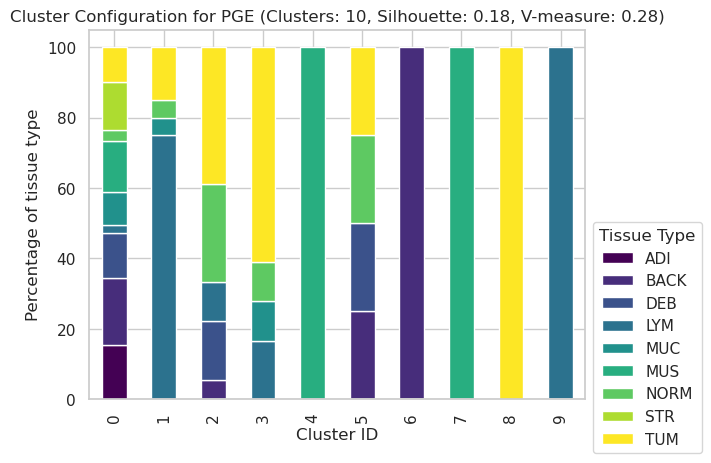

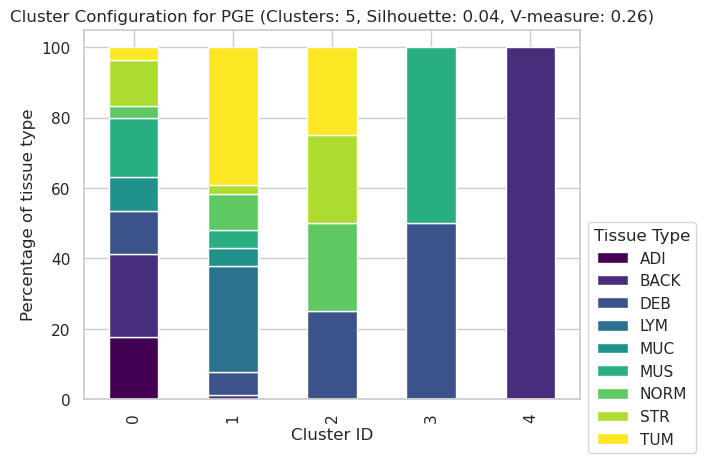

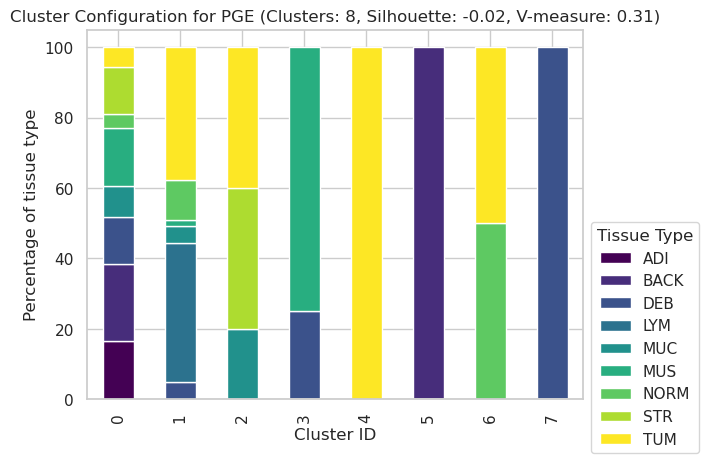

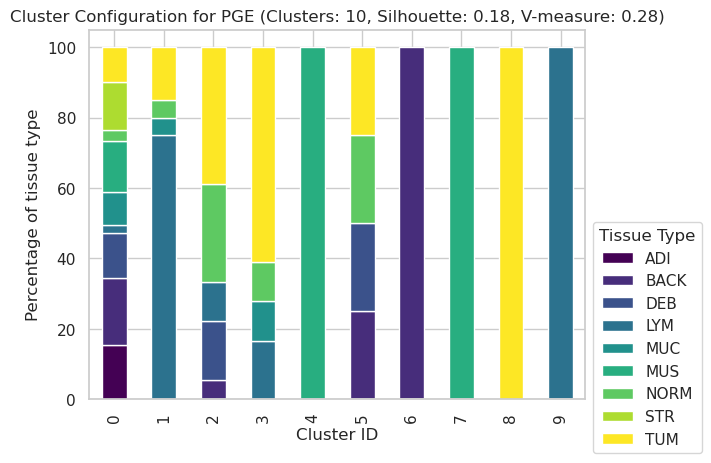

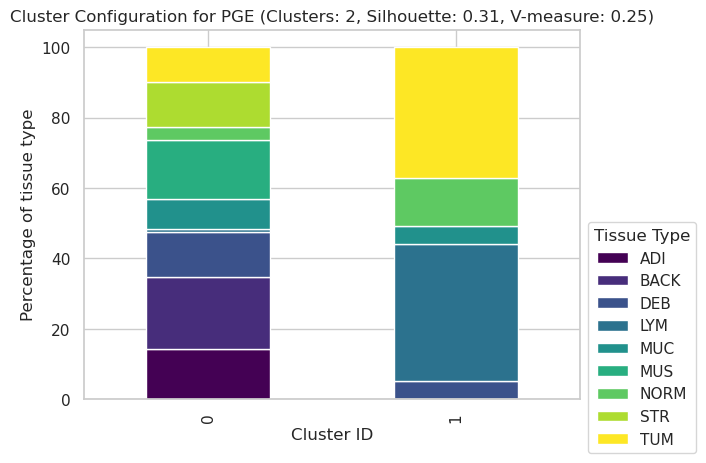

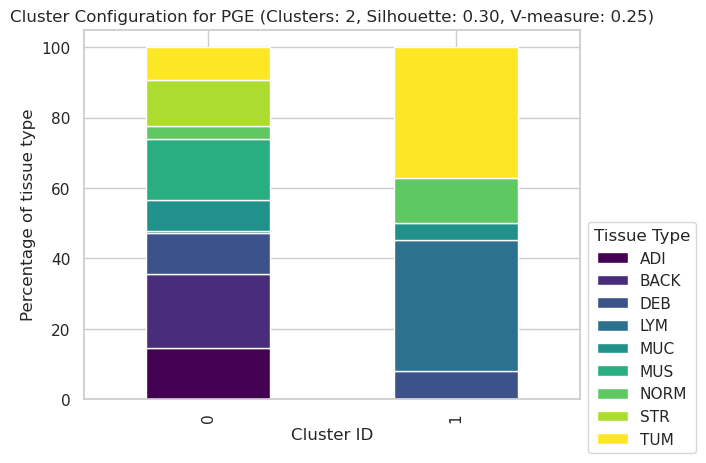

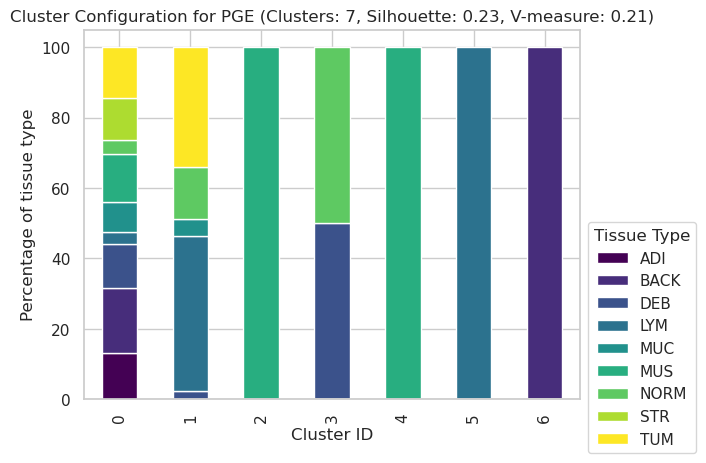

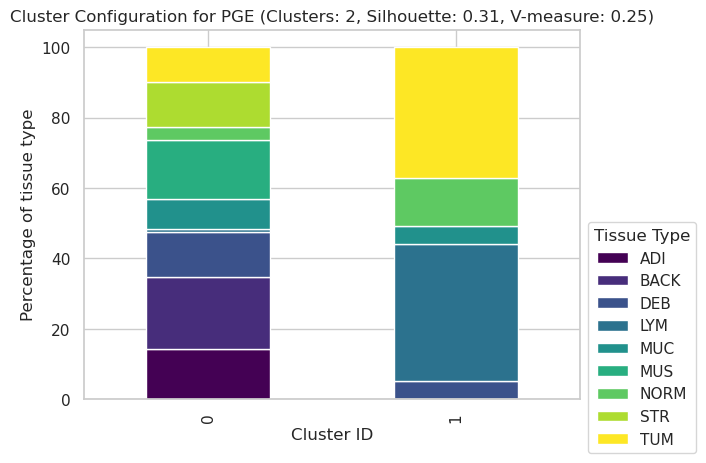

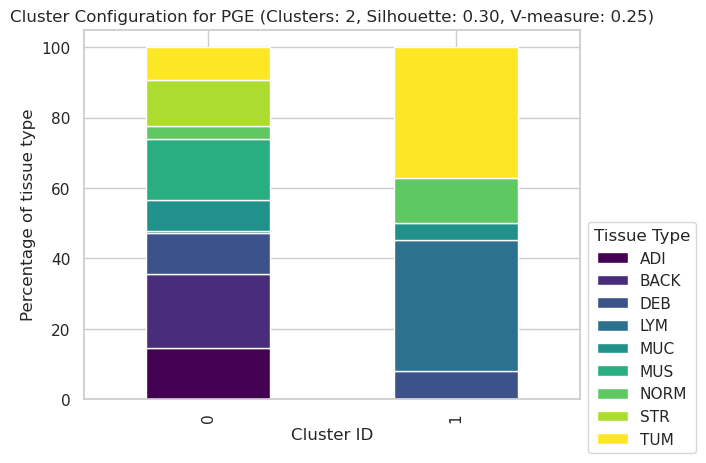

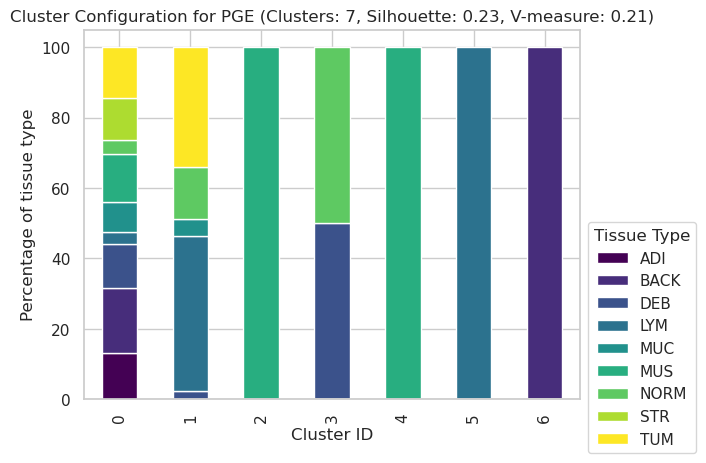

Best cluster size for pge: 10
Best silhouette score and v-measure score for pge: (0.1793222, 0.27753026956054117)


TypeError: float() argument must be a string or a real number, not 'function'

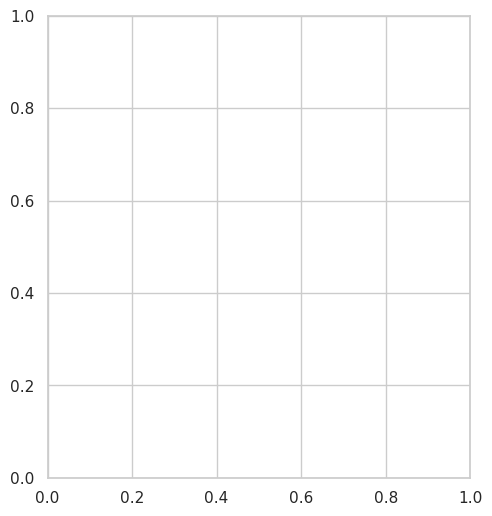

In [16]:
# Main Script for Louvain Clustering Pge representation
for resolution in [0.9, 1, 0.8]:
    for feature_type in feature_types:
        for modularity in modularity_options:
            try:
                representation = 'pge' 
                dataset = datasets[representation][feature_type]

                # Get Testing Data
                filename = np.squeeze(data_content[representation]['file_name'])
                filename = np.array([str(x) for x in filename])
                labels = np.array([x.split('/')[2] for x in filename])
                random.seed(0)
                selected_index = random.sample(list(np.arange(len(dataset))), 200)
                test_data = dataset[selected_index]
                test_label = labels[selected_index]

                # Apply Louvain
                louvain_model = Louvain(resolution=resolution, modularity=modularity, random_state=random_state)
                adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(test_data)))
                louvain_assignment = louvain_model.fit_transform(adjacency_matrix)
                labels = louvain_model.fit_predict(adjacency_matrix)

                # Evaluation Metrics
                counts = np.unique(labels, return_counts=True)
                cluster_size = counts[0].size
                silhouette = silhouette_score(test_data, labels)
                v_measure = v_measure_score(test_label, labels)

                # Update best cluster size and scores
                if representation not in best_cluster_sizes:
                    best_cluster_sizes[representation] = cluster_size
                    best_scores[representation] = (silhouette, v_measure)
                else:
                    if cluster_size > best_cluster_sizes[representation]:
                        best_cluster_sizes[representation] = cluster_size
                        best_scores[representation] = (silhouette, v_measure)

                # Evaluation Metrics
                louvain_results = [int(counts[0].size),
                                silhouette_score(test_data, labels),
                                v_measure_score(test_label, labels)]
                label_proportion = pd.DataFrame({'clusterID': labels, 'type': test_label})
                label_proportion = label_proportion.groupby(['clusterID']).apply(lambda x: x['type'].value_counts(normalize=True)).unstack().fillna(0) * 100
                label_proportion.plot(kind='bar', stacked=True, colormap='viridis')
                sns.set(style="whitegrid")
                plt.title(f'Cluster Configuration for PGE (Clusters: {cluster_size}, Silhouette: {silhouette:.2f}, V-measure: {v_measure:.2f})')
                plt.xlabel('Cluster ID')
                plt.ylabel('Percentage of tissue type')
                plt.legend(title='Tissue Type', loc='upper right', bbox_to_anchor=(1.25, 0.5))
                plt.show()
                
                louvain_results_dictionary = results_headers.copy()
                louvain_results_dictionary.update({representation: louvain_results})
                frame = pd.DataFrame(louvain_results_dictionary).set_index('Metrics')
                fig = plt.figure(figsize=(8, 2))
                ax = fig.add_subplot(111)
                ax.table(cellText=frame.values, rowLabels=frame.index, colLabels=frame.columns, loc="center")
                ax.set_title(f"Louvain Results ({feature_type}): Resolution={resolution}, Modularity={modularity}, Random State={random_state}")
                ax.axis("off")
                plt.show()

                

                

            except Exception as e:
                print(f"Error in: ({feature_type}): Resolution={resolution}, Modularity={modularity}, Random State={random_state}")
                print(e)

# Display Results of Best Cluster Size and Scores at the end of the script
print(f"Best cluster size for {representation}: {best_cluster_sizes[representation]}")
print(f"Best silhouette score and v-measure score for {representation}: {best_scores[representation]}")

# Plotting results of the metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_size, silhouette_score, marker='o', label='Silhouette Score', color='blue')
plt.plot(cluster_size, v_measure_score, marker='o', label='V-measure Score', color='green')
plt.title('Evaluation Metrics vs. Number of Clusters (PGE)')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

In [ ]:
                    #representation = 'resnet50'
                    #representation = 'inceptionv3'
                    #representation = 'vgg16' 